In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw = np.loadtxt('planet1_rv.txt')
jd, rv, e = raw[:, 0], raw[:, 1], raw[:, 2]

In [3]:
from astropy.timeseries import LombScargle
import astropy.units as u

# RV 拟合

$$
RV(t)=v\sin(\omega t+\phi_0)+v_0=v\sin\omega t\cos\phi_0+v\cos\omega t\sin\phi_0+v_0
$$

其中的 $\omega$ 与初相位 $\phi_0$ 耦合在一起，无法同时通过线性回归得到

为此，我们固定 $\omega$，用线性回归估计 $\phi_0$ 和 $v_0$，进而在参数空间 $(v,\omega)$ 中寻找残差最小的点，作为 $v$ 和 $\omega$ 的估计

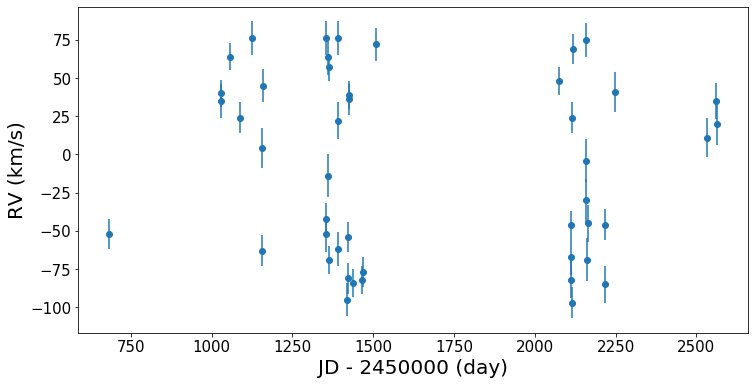

In [4]:
f, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(jd - 2450000, rv, yerr=e, fmt = 'o')

ax.set_xlabel('JD - 2450000 (day)', fontsize=20)
ax.set_ylabel('RV (km/s)', fontsize=20)
ax.tick_params(labelsize=15)

首先考虑线性模型

$$
Y=K_1X_1+K_2X_2+K_0+\epsilon_i
$$

其中我们假设残差项 $\epsilon_i$ 独立同分布于期望为 $0$ 的正态分布

我们已经获取了 $n$ 组数据，$(x_{1,i}, x_{2,i}, y_i),\ i=1,2,\cdots,n$，希望选取 $\hat K_1,\hat K_2,\hat K_0$ 使得残差平方和

$$
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)^2
$$

最小，则必有该残差平方和相对 $K_0,K_1,K_2$ 的偏导数各自为零，即

$$
\left\{
\begin{array}{cc}
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)x_{1,i}=0\\
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)x_{2,i}=0\\
\sum_{i=1}^n(K_1x_{1,i}+K_2x_{2,i}+K_0-y_i)=0\\
\end{array}
\right.
$$

记

$$
\textbf{K}=
\left(
\begin{array}{c}
K_1\\
K_2\\
K_0
\end{array}
\right),\quad
\textbf{X}=
\left(
\begin{array}{c}
x_{1,1}\ x_{2,1}\ 1\\
x_{1,2}\ x_{2,2}\ 1\\
\cdots\\
x_{1,n}\ x_{2,n}\ 1
\end{array}
\right),\quad
\textbf{Y}=
\left(
\begin{array}{c}
y_1\\y_2\\\cdots\\y_n
\end{array}
\right)
$$

则方程组简化为

$$
\textbf{X}'\textbf{X}\textbf{K}=\textbf{X}'\textbf{Y}
$$

可以解得

$$
\textbf{K} = (\textbf{X}'\textbf{X})^{-1}\textbf{X}'\textbf{Y}
$$

进而计算残差平方和

在我们的模型中，

$$
x_{1,i}=\sin(\omega t_i),\quad x_{2,i}=\cos(\omega t_i)
$$

$$
\hat K_0=v_0, \quad \hat K_1=v\cos\phi_0, \quad \hat K_2=v\sin\phi_0
$$

$$
y_{i}=RV(t_i)
$$

据此进行回归运算

In [5]:
def least_square(jd, rv, pmin=0.2, pmax=5, bins=10000):
    omega_temp = 2 * np.pi / np.linspace(pmin, pmax, bins)
    omega_t = np.array([])
    K1_t, K2_t, K0_t = np.array([]), np.array([]), np.array([])
    res_t = np.array([])
    for omega in omega_temp:
        x1 = np.sin(omega * jd)
        x2 = np.cos(omega * jd)
        y = rv

        MatX = np.matrix([x1, x2, np.ones(len(x1))]).T
        MatY = np.matrix([y]).T
        MatK = (MatX.T*MatX)**(-1) * MatX.T * MatY

        K1, K2, K0 = float(MatK[0]), float(MatK[1]), float(MatK[2])

        res = np.sqrt(((K1 * x1 + K2 * x2 + K0 - y)**2).sum())

        omega_t = np.append(omega_t, omega)
        K1_t, K2_t, K0_t = np.append(K1_t,
                                     K1), np.append(K2_t,
                                                    K2), np.append(K0_t, K0)
        res_t = np.append(res_t, res)

    return (omega_t, K1_t, K2_t, K0_t, res_t)

In [6]:
omega_t, K1_t, K2_t, K0_t, res_t = least_square(jd=jd, rv=rv)

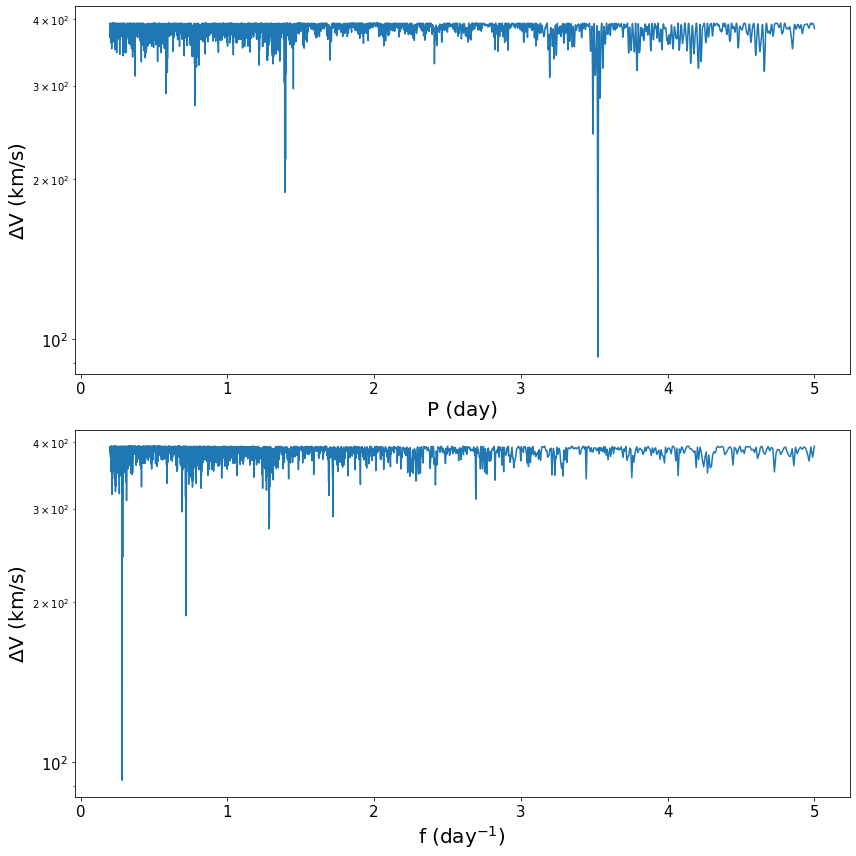

In [7]:
f, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].set_xlabel('P (day)', fontsize=20)
ax[1].set_xlabel('f (day$^{-1}$)', fontsize=20)
ax[0].set_ylabel('$\Delta$V (km/s)', fontsize=20)
ax[1].set_ylabel('$\Delta$V (km/s)', fontsize=20)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)

ax[0].plot((2 * np.pi) / omega_t, res_t)
ax[1].plot(omega_t / (2 * np.pi), res_t)

f.tight_layout()

发现残差最小处周期大致在 $3.515-3.535$ 天之间，进一步绘出此处的残差

In [8]:
omega_t, K1_t, K2_t, K0_t, r = least_square(jd, rv, pmin=3.515, pmax=3.535, bins=10000)
arg = r.argmin()
Omega = omega_t[arg]
K1, K2, K0 = K1_t[arg], K2_t[arg], K0_t[arg]
P = (2 * np.pi) / Omega

0.005478547854785187

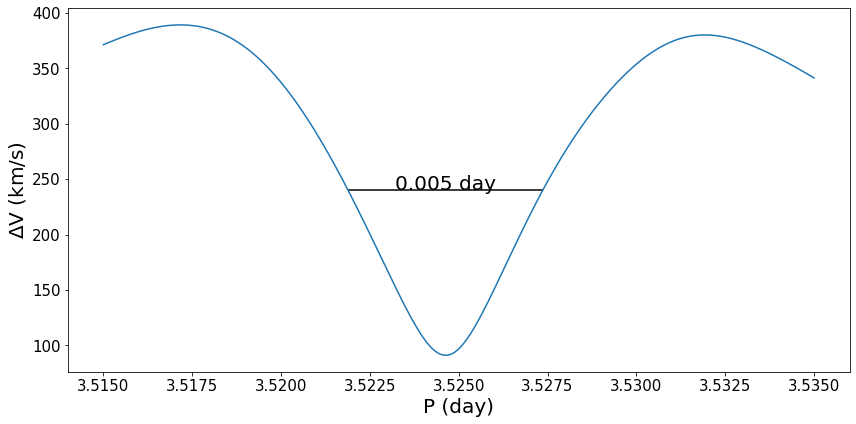

In [9]:
f, ax = plt.subplots(figsize=(12, 6), sharex=True)

ax.set_xlabel('P (day)', fontsize=20)
ax.set_ylabel('$\Delta$V (km/s)', fontsize=20)

args = np.argwhere(r < (r.min() + r.max()) / 2).flatten()

P_t = np.pi *2 / omega_t
ax.plot(P_t, r)
ax.hlines((r.min() + r.max()) / 2, P_t[args].min(), P_t[args].max())
ax.text(P_t[args].mean(), (r.min() + r.max()) / 2,
        '0.005 day',
        size=20,
        horizontalalignment='center')
ax.tick_params(labelsize=15)

f.tight_layout()
FWHM_dv = P_t[args].max() - P_t[args].min()
FWHM_dv

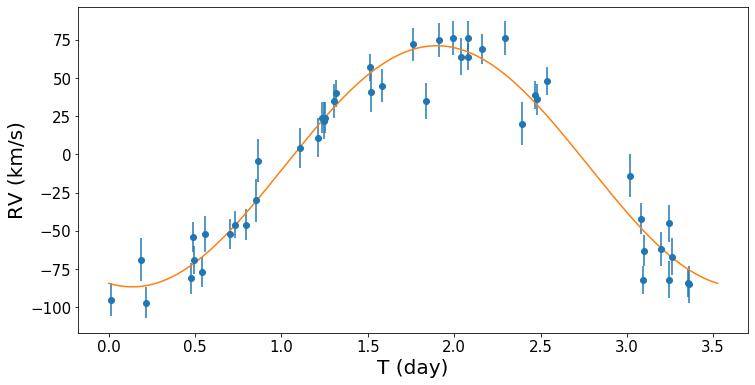

In [10]:
v = np.sqrt(K1**2 + K2**2)
phi = np.arctan2(K2, K1)
v0 = K0
t = np.linspace(0, P, 1000)
def pred(t):
    return (v * np.sin(Omega * t + phi) + v0)

f, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel('T (day)', fontsize=20)
ax.set_ylabel('RV (km/s)', fontsize=20)
ax.tick_params(labelsize=15)

ax.errorbar(jd % P, rv, yerr=e, fmt='o')
ax.plot(t, pred(t))

In [11]:
print('v_0 = {:.1f} km/s'.format(v0))
print('v = {:.1f} km/s'.format(v))
print('phi = {:.1f} deg'.format(phi * 180 / np.pi))
print('P = {:.4f} day'.format(P))

v_0 = -7.8 km/s
v = 78.9 km/s
phi = -104.0 deg
P = 3.5246 day


# 误差分析

## 残差引入的误差

根据线性回归的理论，估计量 $K$ 的协方差为

$$
\operatorname{cov}({K})=\sigma^{2}\left(X^{\prime} X\right)^{-1}
$$

其中 $\sigma^2$ 是残差 $\epsilon_i$ 的方差，对于有两个自由度的模型，其无偏估计是

$$
{\sigma}^2=\frac{1}{n-2-1}\sum_i^n{e_i^2}
$$

In [12]:
x1 = np.sin(Omega * jd)
x2 = np.cos(Omega * jd)
y = rv

MatX = np.matrix([x1, x2, np.ones(len(x1))]).T
MatY = np.matrix([y]).T
MatK = (MatX.T * MatX)**(-1) * MatX.T * MatY

K1, K2, K0 = float(MatK[0]), float(MatK[1]), float(MatK[2])

err2 = ((K1 * x1 + K2 * x2 + K0 - y)**2).sum()
sigma2 = err2 / (len(jd) - 2 - 1)
covK = sigma2 * (MatX.T * MatX)**(-1)

从而我们可以得到三个估计量各自的方差

In [13]:
Delta2_K1_res = covK[0,0]
Delta2_K2_res = covK[1,1]
Delta2_K0_res = covK[2,2]

print('K_1 / err (km/s) {:.1f} / {:.1f}'.format(K1, np.sqrt(Delta2_K1_res)))
print('K_2 / err (km/s) {:.1f} / {:.1f}'.format(K2, np.sqrt(Delta2_K2_res)))
print('K_0 / err (km/s) {:.1f} / {:.1f}'.format(K0, np.sqrt(Delta2_K0_res)))

K_1 / err (km/s) -19.0 / 3.0
K_2 / err (km/s) -76.6 / 2.8
K_0 / err (km/s) -7.8 / 2.1


## 测量引入的误差

以 $K_1$ 为例，测量量 $y_i$ 引入的方差为

$$
\Delta K_{1,i}^2=\eta^2 x_{i,1}^2\sigma_{y_i}^2\Rightarrow\Delta K_{1}^2=\eta^2 \sum_{i=1}^n x_{i,1}^2\sigma_{y_i}^2
$$

其中 $\eta$ 为一个系数，满足

$$
K_i = K_{1}^2=\eta \sum_{i=1}^n x_{i,1}y_i
$$

从而

$$
\frac{\Delta K_1^2}{K_1^2}=\frac{\sum_{i=1}^{n}x_{1,i}^2\sigma_{y_i}^2}{YX_1^2}
$$

同理

$$
\frac{\Delta K_2^2}{K_2^2}=\frac{\sum_{i=1}^{n}x_{2,i}^2\sigma_{y_i}^2}{YX_2^2}
$$

$$
\frac{\Delta K_0^2}{K_0^2}=\frac{\sum_{i=1}^{n}\sigma_{y_i}^2}{Y^2}
$$

In [14]:
X1 = x1.sum()
X2 = x2.sum()
YX1 = (y * x1).sum()
YX2 = (y * x2).sum()
Y = y.sum()

Delta2_K1_mes = K1**2 * (x1**2 + e**2).sum() / (YX1**2)
Delta2_K2_mes = K2**2 * (x2**2 + e**2).sum() / (YX2**2)
Delta2_K0_mes = K0**2 * (e**2).sum() / (Y**2)

print('K_1 / err (km/s) {:.1f} / {:.1f}'.format(K1, np.sqrt(Delta2_K1_mes)))
print('K_2 / err (km/s) {:.1f} / {:.1f}'.format(K2, np.sqrt(Delta2_K2_mes)))
print('K_0 / err (km/s) {:.1f} / {:.1f}'.format(K0, np.sqrt(Delta2_K0_mes)))

K_1 / err (km/s) -19.0 / 3.5
K_2 / err (km/s) -76.6 / 3.2
K_0 / err (km/s) -7.8 / 1.7


In [15]:
Delta2_K1 = Delta2_K1_res + Delta2_K1_mes
Delta2_K2 = Delta2_K2_res + Delta2_K2_mes
Delta2_K0 = Delta2_K0_res + Delta2_K0_mes

print('K_1 / err (km/s) {:.1f} / {:.1f}'.format(K1, np.sqrt(Delta2_K1)))
print('K_2 / err (km/s) {:.1f} / {:.1f}'.format(K2, np.sqrt(Delta2_K2)))
print('K_0 / err (km/s) {:.1f} / {:.1f}'.format(K0, np.sqrt(Delta2_K0)))

K_1 / err (km/s) -19.0 / 4.6
K_2 / err (km/s) -76.6 / 4.3
K_0 / err (km/s) -7.8 / 2.7


进而，对于

$$
N=f(x_1,\cdots,x_n)
$$

可以由误差传递公式

$$
\frac{\sigma_{N}}{N}=\sqrt{\sum_{i=1}^n\left(\frac{\partial \ln f}{\partial x_{i}}\right)^{2}\sigma_{x_i}^2}
$$

估计几个观测量的误差

$$
\sigma_{v_0}=\sigma_{K_0}
$$

$$
\sigma_{v}=v\sqrt{\frac{K_1^2\sigma^2_{K_1}+K_2^2\sigma_{K_2}^2}{\left({K_1^2+K_2^2}\right)^2}}=\sqrt{\frac{K_1^2\sigma^2_{K_1}+K_2^2\sigma_{K_2}^2}{K_1^2+K_2^2}}
$$

$$
\sigma_{\phi}=\phi\sqrt{\frac{K_2^2\sigma^2_{K_1}+K_1^2\sigma_{K_2}^2}{\left({K_1^2+K_2^2}\right)^2\arctan^2(K_2/K_1)}}=\sqrt{\frac{K_2^2\sigma^2_{K_1}+K_1^2\sigma_{K_2}^2}{\left({K_1^2+K_2^2}\right)^2}}
$$

再加上已经通过半高全宽估计的周期的误差，最终得到

In [16]:
sigma_P = FWHM_dv
sigma_v0 = np.sqrt(Delta2_K0)
sigma_v = np.sqrt((K1**2 * Delta2_K1 + K2**2 * Delta2_K2) / (K1**2 + K2**2))
sigma_phi = np.sqrt((K1**2 * Delta2_K2 + K2**2 * Delta2_K1) / (K1**2 + K2**2)**2)
print('P {:.4f} {:.4f} day'.format(P, sigma_P))
print('v_0 {:.1f} {:.1f} km/s'.format(v0, sigma_v0))
print('v {:.1f} {:.1f} km/s'.format(v, sigma_v))
print('phi {:.1f} {:.1f} deg'.format(phi * 180 / np.pi,
                                     sigma_phi * 180 / np.pi))

P 3.5246 0.0055 day
v_0 -7.8 2.7 km/s
v 78.9 4.3 km/s
phi -104.0 3.3 deg


$$
P=3.5246\pm0.0055 \text{ day},\quad v_0=-7.8\pm2.7\text{ km/s}, \quad v=78.9\pm4.3\text{ km/s},\quad
\phi=-104.0\pm3.3 \deg
$$